In [103]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

SEED = 42
np.random.seed(SEED)

In [2]:
# Read in the data
loan_data_filename = '/Users/ankurmanikandan/Desktop/Missiona Lane Data Assessment/drive-download-20200505T201443Z-001/training_data.csv'
loan_data = pd.read_csv(loan_data_filename, skiprows=1)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,4,5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_data.head(10)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,desc,...,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,total_pymnt,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal
0,10129403,11981032.0,7550,36 months,16.24%,3 years,RENT,28000.0,Current,NaN,...,96.0,8.40,0.0,17.0,72%,4000.0,1864.38,NaN,3828.953801,5759.0
1,10149342,12000897.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Current,Borrower added on 12/31/13 > Combining high ...,...,53.9,22.87,0.0,8.0,61.2%,35700.0,6198.22,NaN,34359.940727,114834.0
2,10129454,11981072.0,12000,36 months,10.99%,4 years,RENT,60000.0,Current,Borrower added on 12/31/13 > I would like to...,...,15.9,4.62,1.0,3.0,24%,18100.0,2748.84,NaN,16416.617758,7137.0
3,10149577,12001118.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,Fully Paid,NaN,...,67.1,18.55,1.0,3.0,54.6%,42200.0,29150.98,NaN,38014.149757,799592.0
4,10139658,11991209.0,12000,36 months,13.53%,10+ years,RENT,40000.0,Current,NaN,...,79.6,16.94,0.0,17.0,68.8%,7000.0,2851.80,53.0,6471.462236,13605.0
5,10119590,11971211.0,11500,60 months,22.90%,4 years,RENT,32760.0,Current,Borrower added on 12/31/13 > This loan is fo...,...,70.1,27.06,0.0,14.0,70.9%,9000.0,2264.66,NaN,9750.303073,24724.0
6,10149488,12001033.0,4800,36 months,10.99%,2 years,MORTGAGE,39600.0,Current,Borrower added on 12/31/13 > Just bought a h...,...,16.1,2.49,2.0,3.0,16.1%,25700.0,1257.04,NaN,24491.154755,4136.0
7,10159611,12011228.0,10000,36 months,9.67%,7 years,MORTGAGE,102000.0,Current,NaN,...,89.4,15.55,0.0,8.0,44.4%,9200.0,2247.60,54.0,9401.851428,39143.0
8,10129506,11981122.0,20800,36 months,13.53%,10+ years,RENT,81500.0,Current,Borrower added on 12/31/13 > My goal is to p...,...,54.6,16.73,2.0,0.0,54.5%,15000.0,4942.08,71.0,15014.232744,23473.0
9,10149526,12001069.0,27600,60 months,19.97%,6 years,MORTGAGE,73000.0,Current,Borrower added on 12/31/13 > I had some wate...,...,74.7,23.13,1.0,6.0,82.8%,19200.0,5114.91,7.0,20011.337149,241609.0


In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197787 entries, 0 to 197786
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           197787 non-null  int64  
 1   member_id                    188123 non-null  float64
 2   loan_amnt                    197787 non-null  int64  
 3   term                         188123 non-null  object 
 4   int_rate                     188123 non-null  object 
 5   emp_length                   180246 non-null  object 
 6   home_ownership               188123 non-null  object 
 7   annual_inc                   188123 non-null  float64
 8   loan_status                  188123 non-null  object 
 9   desc                         81461 non-null   object 
 10  purpose                      188123 non-null  object 
 11  percent_bc_gt_75             179096 non-null  float64
 12  bc_util                      179012 non-null  float64
 13 

# Challenge

Build a model that predicts at **application time** whether an applicant will repay the loan they are requesting.

In [5]:
# Create the target label - 'loan_status'
loan_data.loan_status.value_counts(dropna=False)

Current               140116
Fully Paid             33309
NaN                     9664
Charged Off             9178
Late (31-120 days)      3077
In Grace Period         1570
Late (16-30 days)        780
Default                   93
Name: loan_status, dtype: int64

In [6]:
# Let us drop the NaNs
loan_data.dropna(subset=['loan_status'], inplace=True)
loan_data.loan_status.value_counts(dropna=False)

Current               140116
Fully Paid             33309
Charged Off             9178
Late (31-120 days)      3077
In Grace Period         1570
Late (16-30 days)        780
Default                   93
Name: loan_status, dtype: int64

In [7]:
# Determine which loan statuses are considered 'Default'
default_loan_status = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']
loan_data['target'] = np.where(loan_data.loan_status.isin(default_loan_status), 1, 0)
loan_data.target.value_counts(dropna=False)

0    174995
1     13128
Name: target, dtype: int64

In [8]:
# We know that the default status needs to be predicted at application time, so let us drop the unwanted columns
new_loan_data = loan_data.copy()  # create a copy of the original df
drop_cols = ['id', 'member_id', 'int_rate', 'total_pymnt', 'loan_status']
new_loan_data.drop(columns=drop_cols, inplace=True)
new_loan_data.head(10)

,loan_amnt,term,emp_length,home_ownership,annual_inc,desc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,target
0,7550,36 months,3 years,RENT,28000.0,NaN,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,0
1,27050,36 months,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.2%,35700.0,NaN,34359.940727,114834.0,0
2,12000,36 months,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,0.0,15.9,4.62,1.0,3.0,24%,18100.0,NaN,16416.617758,7137.0,0
3,28000,36 months,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,16.7,67.1,18.55,1.0,3.0,54.6%,42200.0,NaN,38014.149757,799592.0,0
4,12000,36 months,10+ years,RENT,40000.0,NaN,debt_consolidation,33.3,79.6,16.94,0.0,17.0,68.8%,7000.0,53.0,6471.462236,13605.0,0
5,11500,60 months,4 years,RENT,32760.0,Borrower added on 12/31/13 > This loan is fo...,debt_consolidation,50.0,70.1,27.06,0.0,14.0,70.9%,9000.0,NaN,9750.303073,24724.0,0
6,4800,36 months,2 years,MORTGAGE,39600.0,Borrower added on 12/31/13 > Just bought a h...,home_improvement,0.0,16.1,2.49,2.0,3.0,16.1%,25700.0,NaN,24491.154755,4136.0,0
7,10000,36 months,7 years,MORTGAGE,102000.0,NaN,debt_consolidation,66.7,89.4,15.55,0.0,8.0,44.4%,9200.0,54.0,9401.851428,39143.0,0
8,20800,36 months,10+ years,RENT,81500.0,Borrower added on 12/31/13 > My goal is to p...,debt_consolidation,50.0,54.6,16.73,2.0,0.0,54.5%,15000.0,71.0,15014.232744,23473.0,0
9,27600,60 months,6 years,MORTGAGE,73000.0,Borrower added on 12/31/13 > I had some wate...,debt_consolidation,80.0,74.7,23.13,1.0,6.0,82.8%,19200.0,7.0,20011.337149,241609.0,0


In [9]:
new_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    188123 non-null  int64  
 1   term                         188123 non-null  object 
 2   emp_length                   180246 non-null  object 
 3   home_ownership               188123 non-null  object 
 4   annual_inc                   188123 non-null  float64
 5   desc                         81461 non-null   object 
 6   purpose                      188123 non-null  object 
 7   percent_bc_gt_75             179096 non-null  float64
 8   bc_util                      179012 non-null  float64
 9   dti                          188123 non-null  float64
 10  inq_last_6mths               188123 non-null  float64
 11  mths_since_recent_inq        160263 non-null  float64
 12  revol_util                   187998 non-null  object 
 13 

In [10]:
# Investigate loan amount
loan_data.loan_amnt.describe()

count    188123.000000
mean      14354.545962
std        8115.066458
min        1000.000000
25%        8000.000000
50%       12175.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

<IPython.core.display.Javascript object>


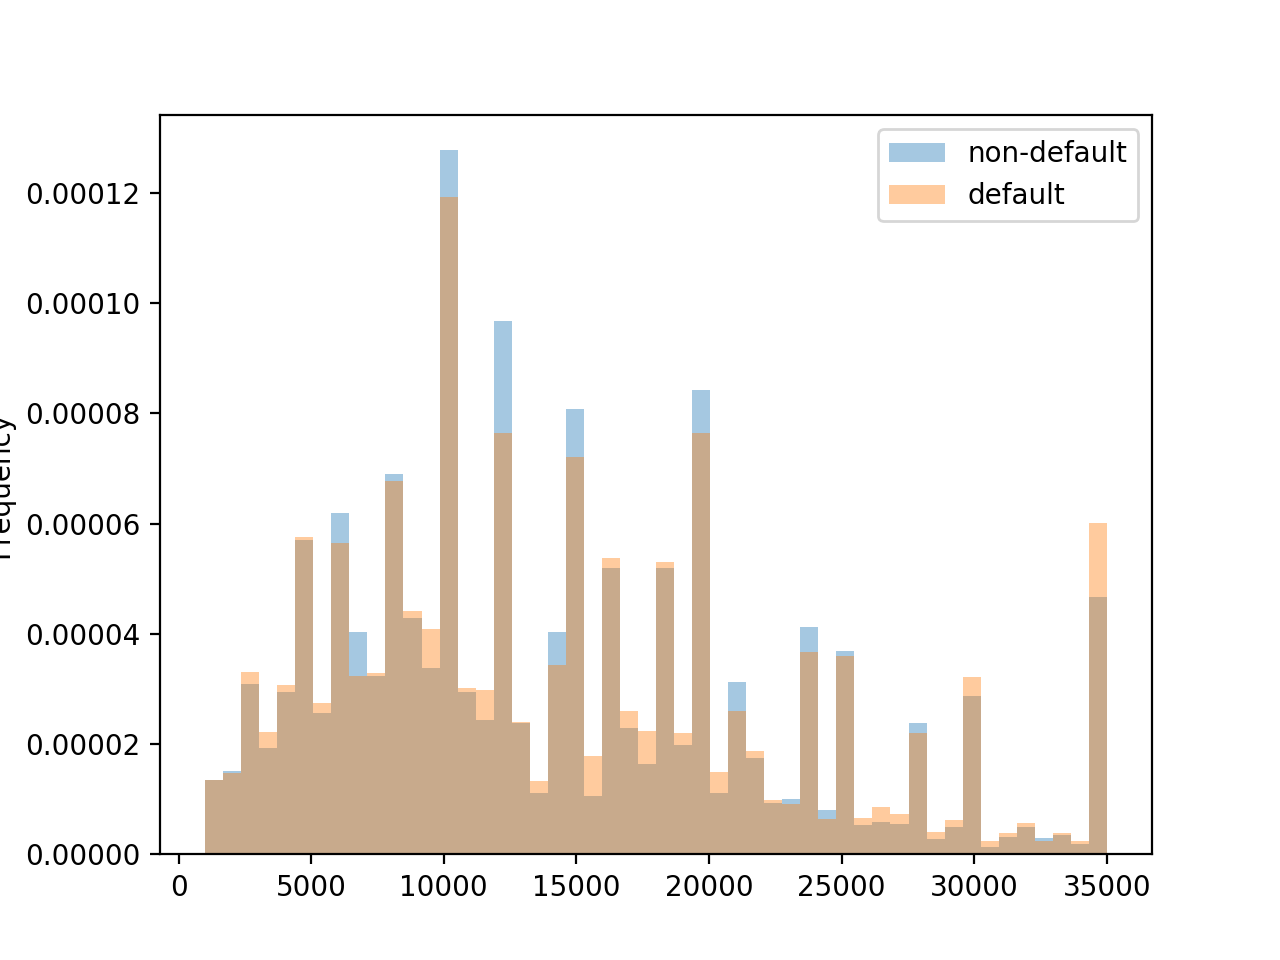

In [11]:
fig, ax = plt.subplots()
loan_data.loc[loan_data.target == 0, 'loan_amnt'].plot.hist(bins=50, alpha=0.4, 
                                                            density=True, label='non-default', ax=ax)
loan_data.loc[loan_data.target == 1, 'loan_amnt'].plot.hist(bins=50, alpha=0.4, 
                                                            density=True, label='default', ax=ax)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


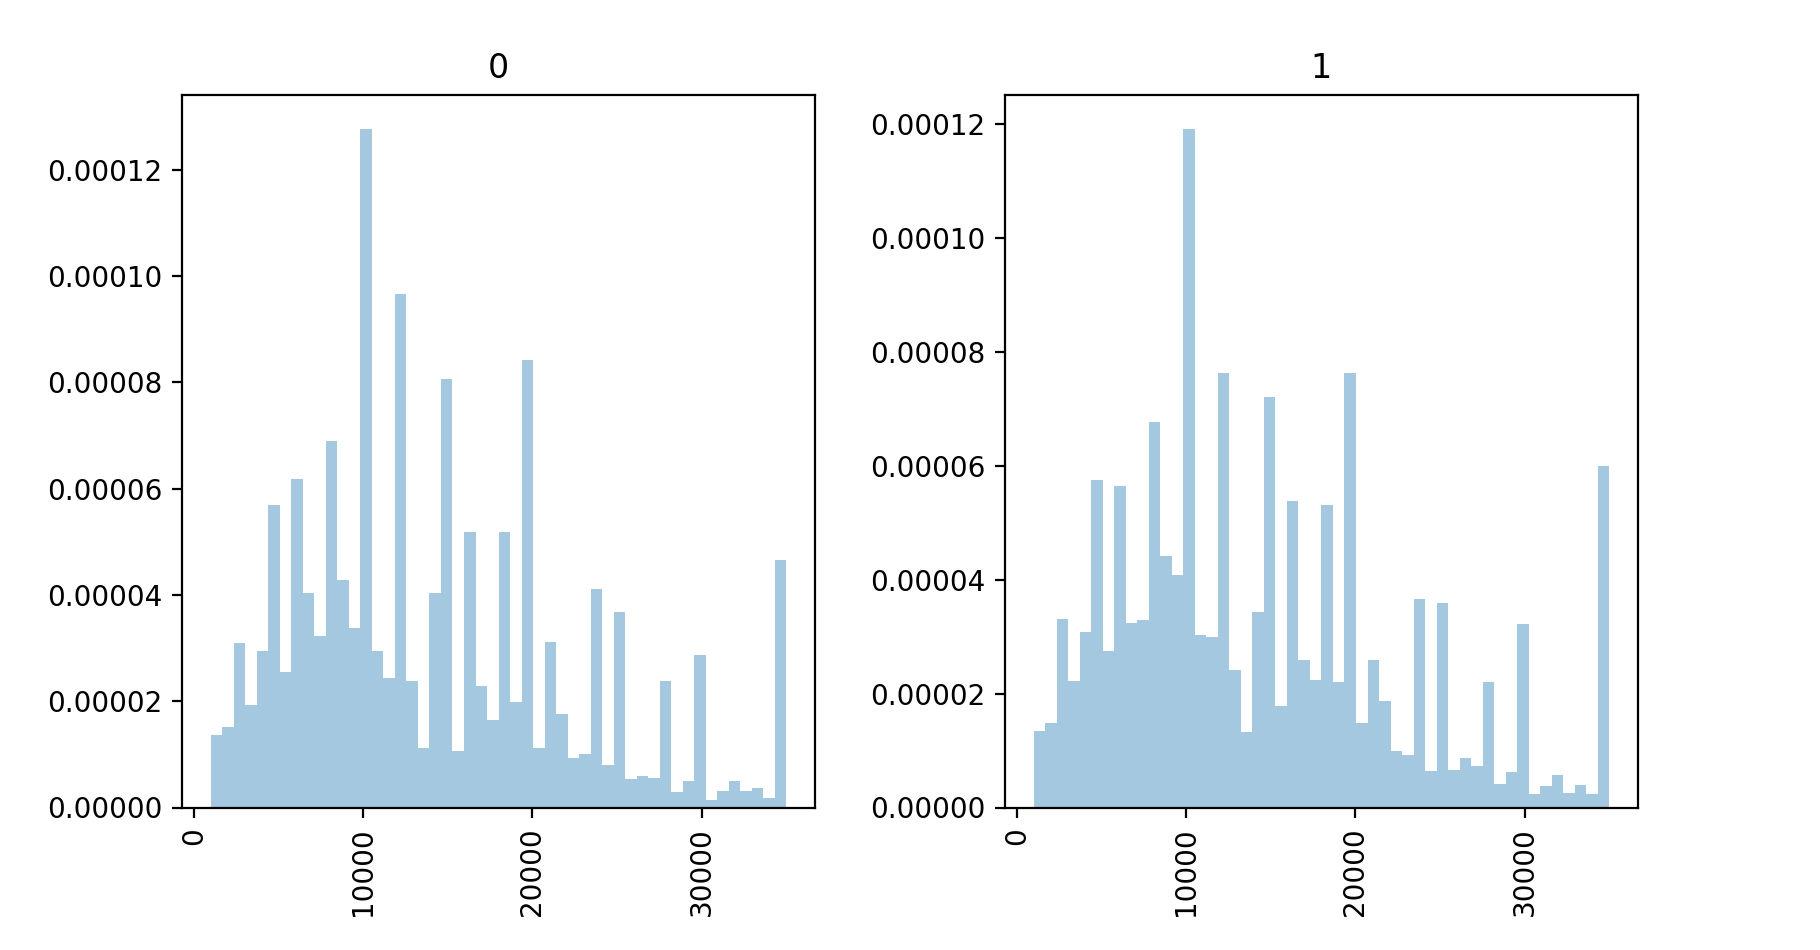

In [78]:
fig, ax = plt.subplots()
loan_data.loan_amnt.hist(bins=50, alpha=0.4, ax=ax, density=True, by=loan_data.target)
plt.show()

<IPython.core.display.Javascript object>


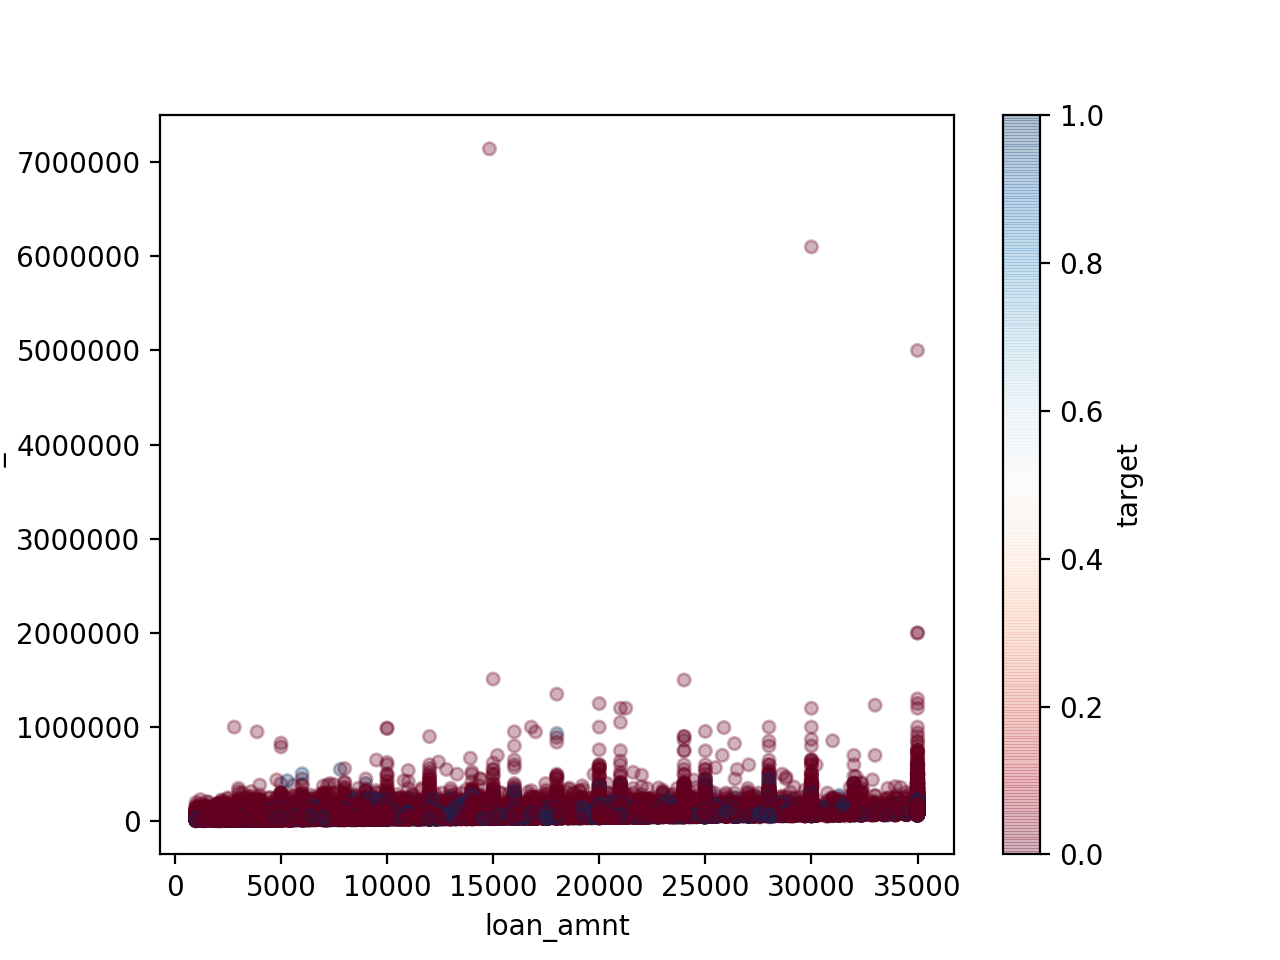

In [92]:
fig, ax = plt.subplots()
loan_data.plot.scatter(x='loan_amnt', y='annual_inc', c='target', ax=ax, cmap='RdBu', alpha=0.3)
plt.show()

<IPython.core.display.Javascript object>


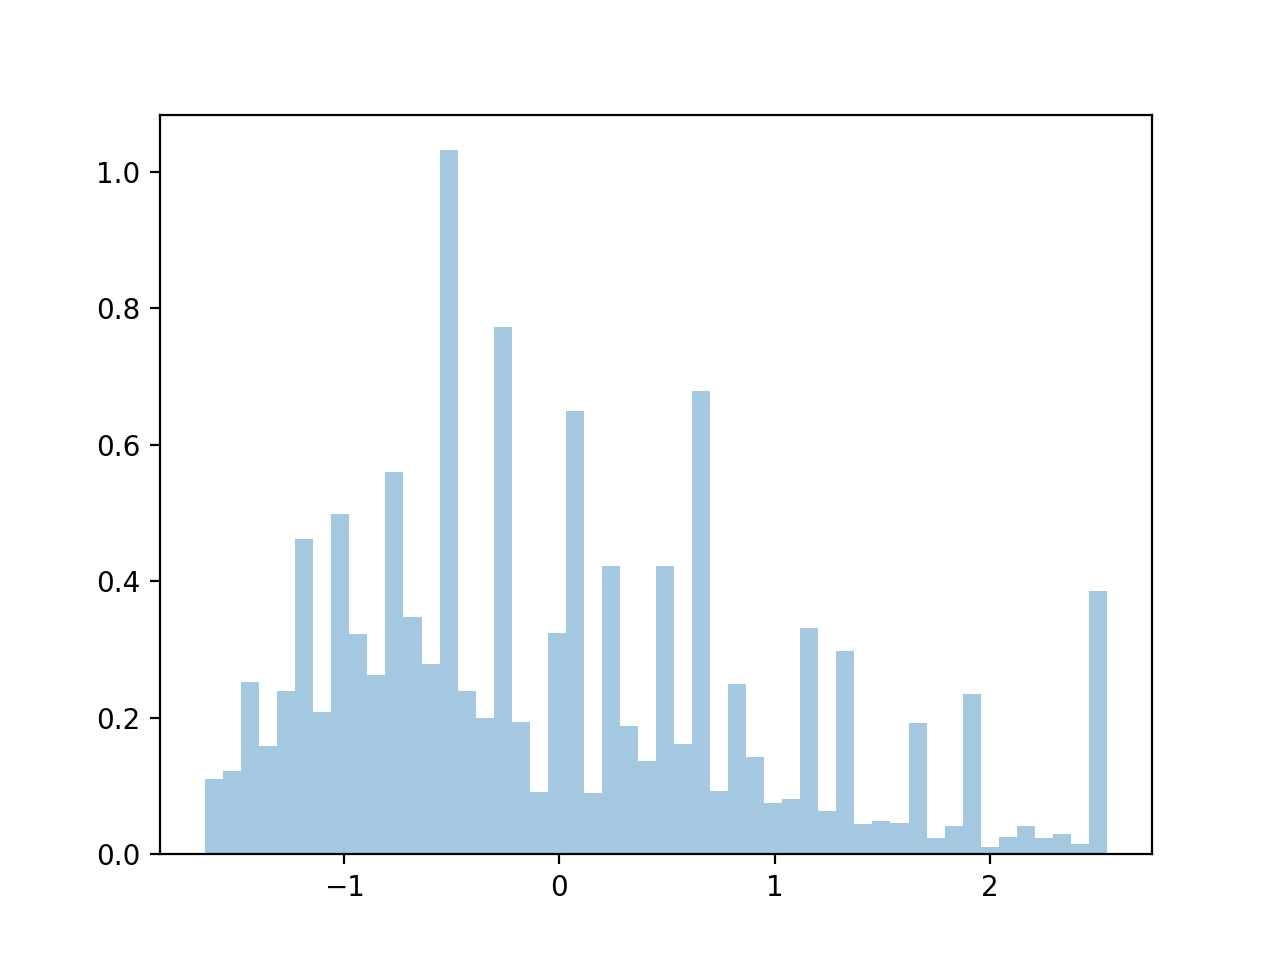

In [104]:
sc = StandardScaler()
loan_amt_stnd = sc.fit_transform(loan_data.loan_amnt.values.reshape(-1, 1))

fig, ax = plt.subplots()
plt.hist(loan_amt_stnd, bins=50, alpha=0.4, density=True)
plt.show()

<IPython.core.display.Javascript object>


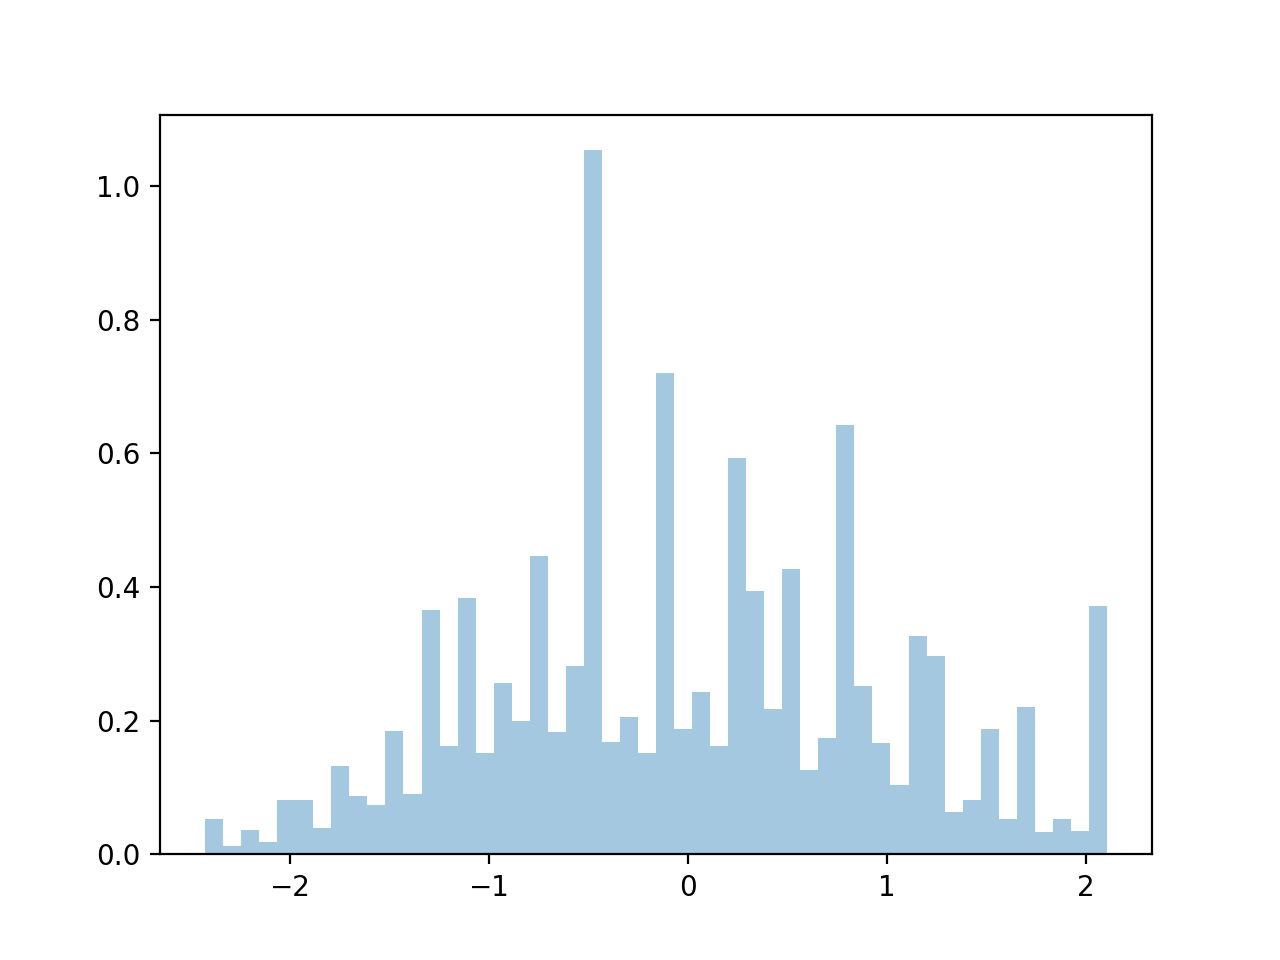

In [105]:
# loan_amt_log = np.log(1 + loan_data.loan_amnt)
# loan_amt_log_recp = 1. / np.log(1 + loan_data.loan_amnt)
loan_amt_sqrt = np.sqrt(loan_data.loan_amnt)

sc = StandardScaler()
loan_amt_sqrt_stnd = sc.fit_transform(loan_amt_sqrt.values.reshape(-1, 1))

fig, ax = plt.subplots()
plt.hist(loan_amt_sqrt_stnd, bins=50, alpha=0.4, density=True)
plt.show()

<IPython.core.display.Javascript object>


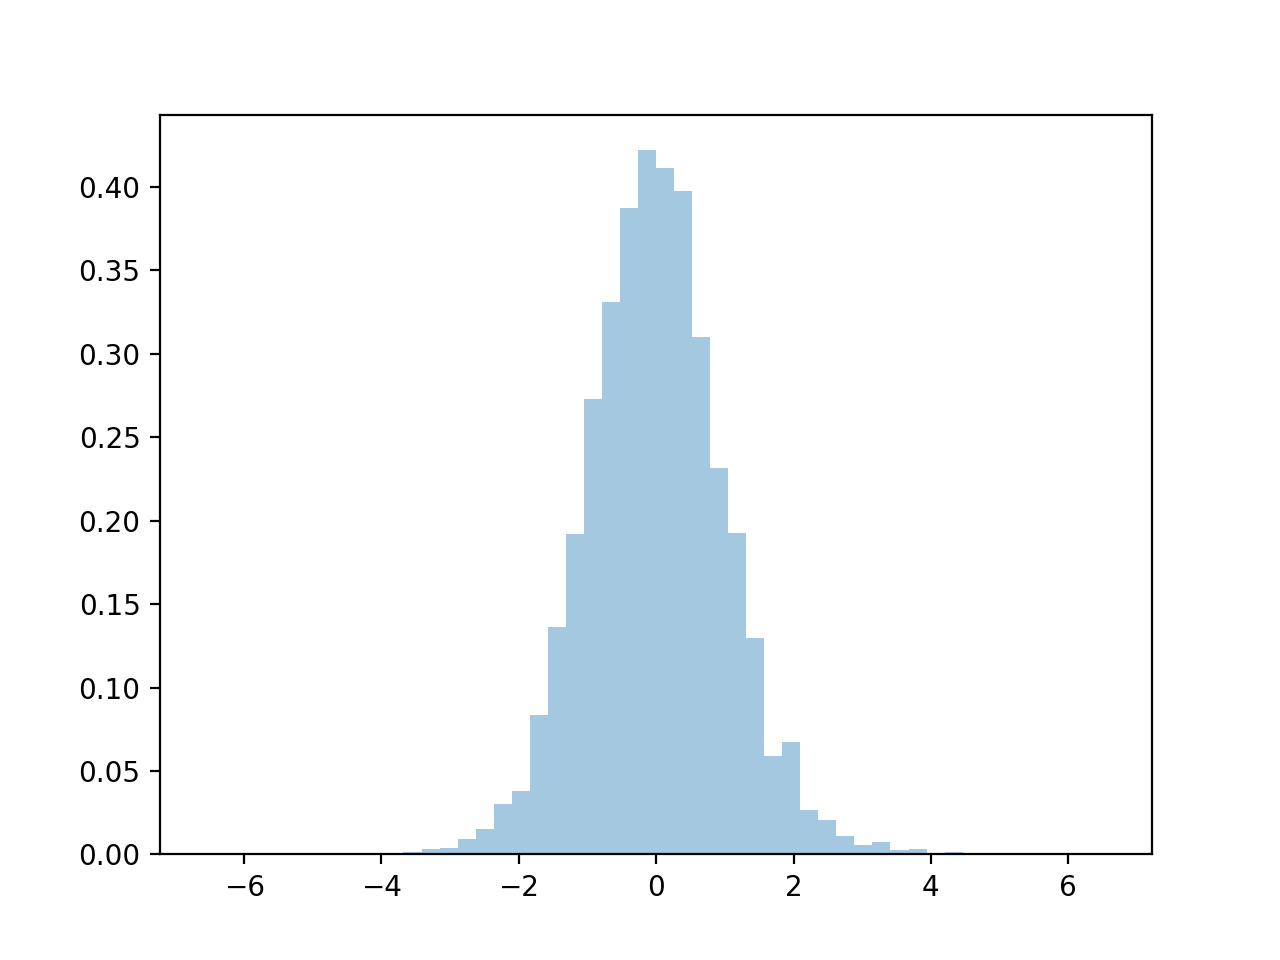

In [106]:
annual_inc_log = np.log(1+loan_data.annual_inc)
annual_inc_log_recp = 1. / np.log(1+loan_data.annual_inc)
annual_inc_sqrt = np.sqrt(loan_data.annual_inc)

sc = StandardScaler()
annual_inc_log_recp_stnd = sc.fit_transform(annual_inc_log_recp.values.reshape(-1, 1))

fig, ax = plt.subplots()
plt.hist(annual_inc_log_recp_stnd, bins=50, alpha=0.4, density=True)
plt.show()

In [107]:
pd.Series(annual_inc_log_recp_stnd.reshape(-1,)).describe()

count    1.881230e+05
mean    -7.864608e-15
std      1.000003e+00
min     -6.566771e+00
25%     -6.622859e-01
50%     -1.328827e-02
75%      6.384186e-01
max      6.562918e+00
dtype: float64

In [12]:
loan_data.term.value_counts(dropna=False)

 36 months    143850
 60 months     44273
Name: term, dtype: int64

<IPython.core.display.Javascript object>


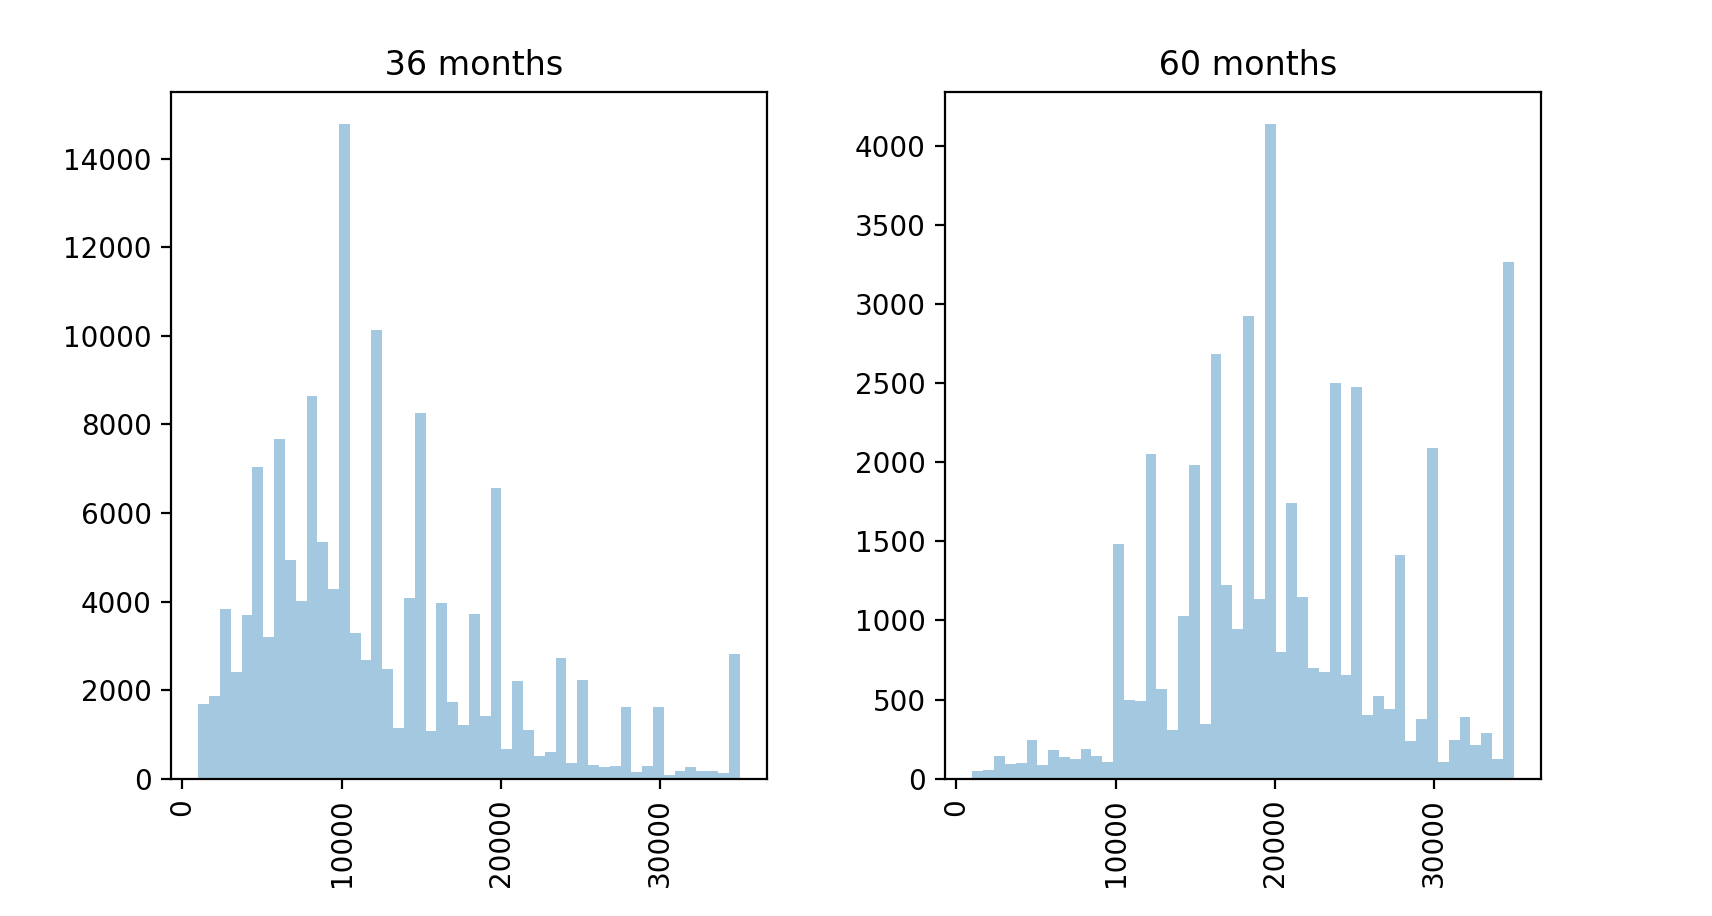

In [95]:
fig, ax = plt.subplots()
loan_data.loan_amnt.hist(bins=50, alpha=0.4, by=loan_data.term, ax=ax)
plt.show()

<IPython.core.display.Javascript object>


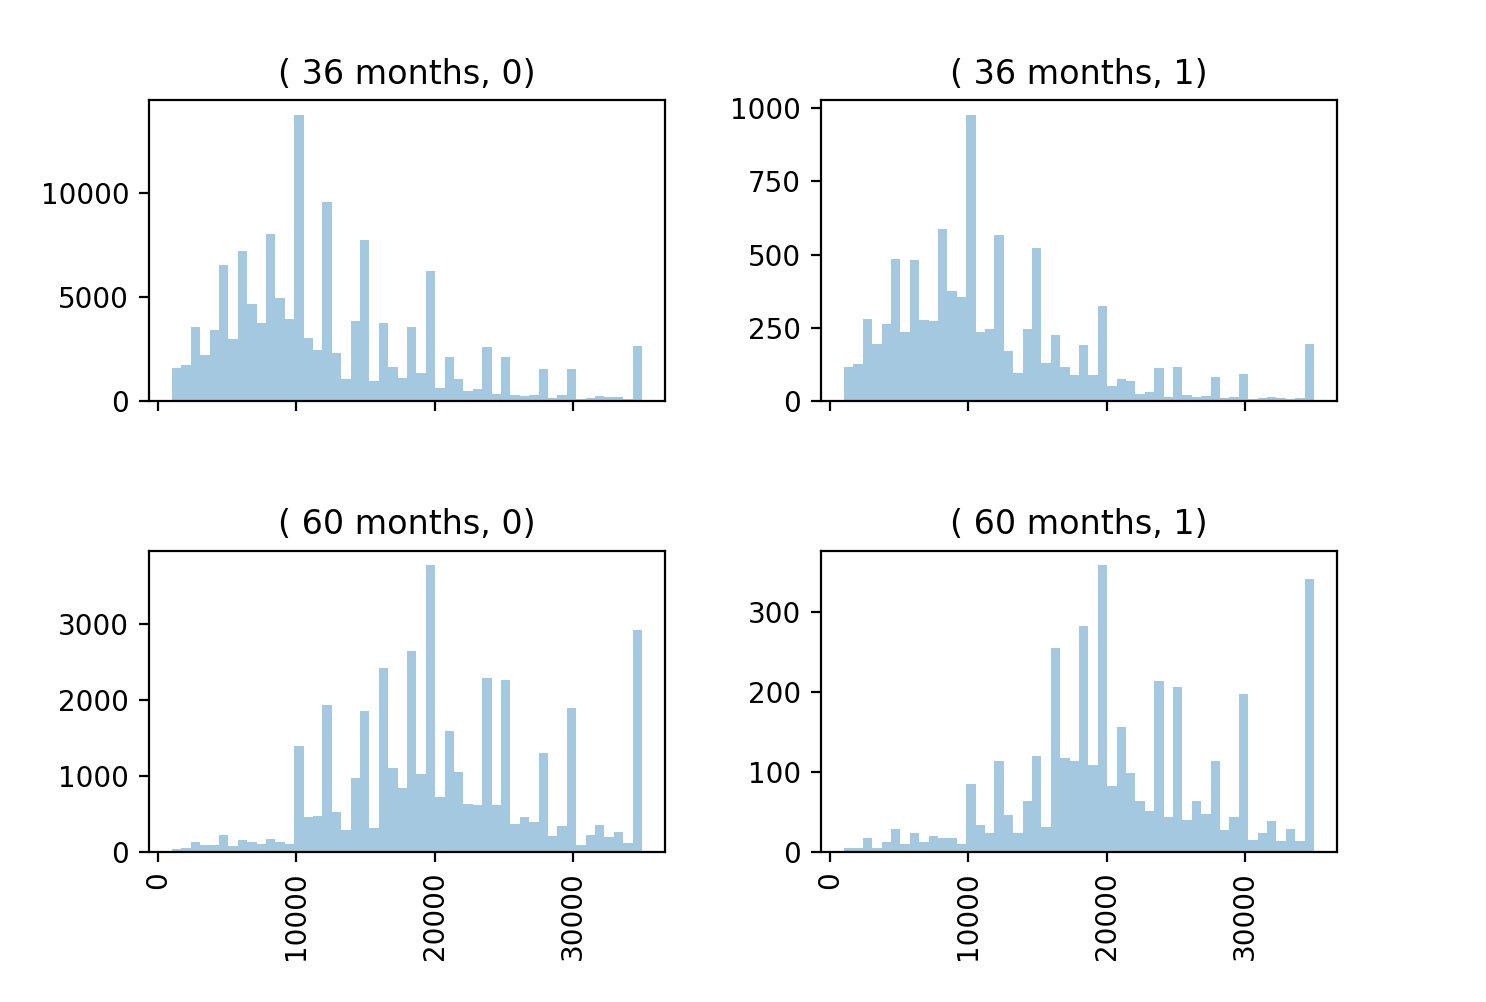

In [101]:
fig, ax = plt.subplots()
loan_data.hist(column='loan_amnt', by=['term', 'target'], bins=50, ax=ax, alpha=0.4, sharex=True)
plt.show()

<IPython.core.display.Javascript object>


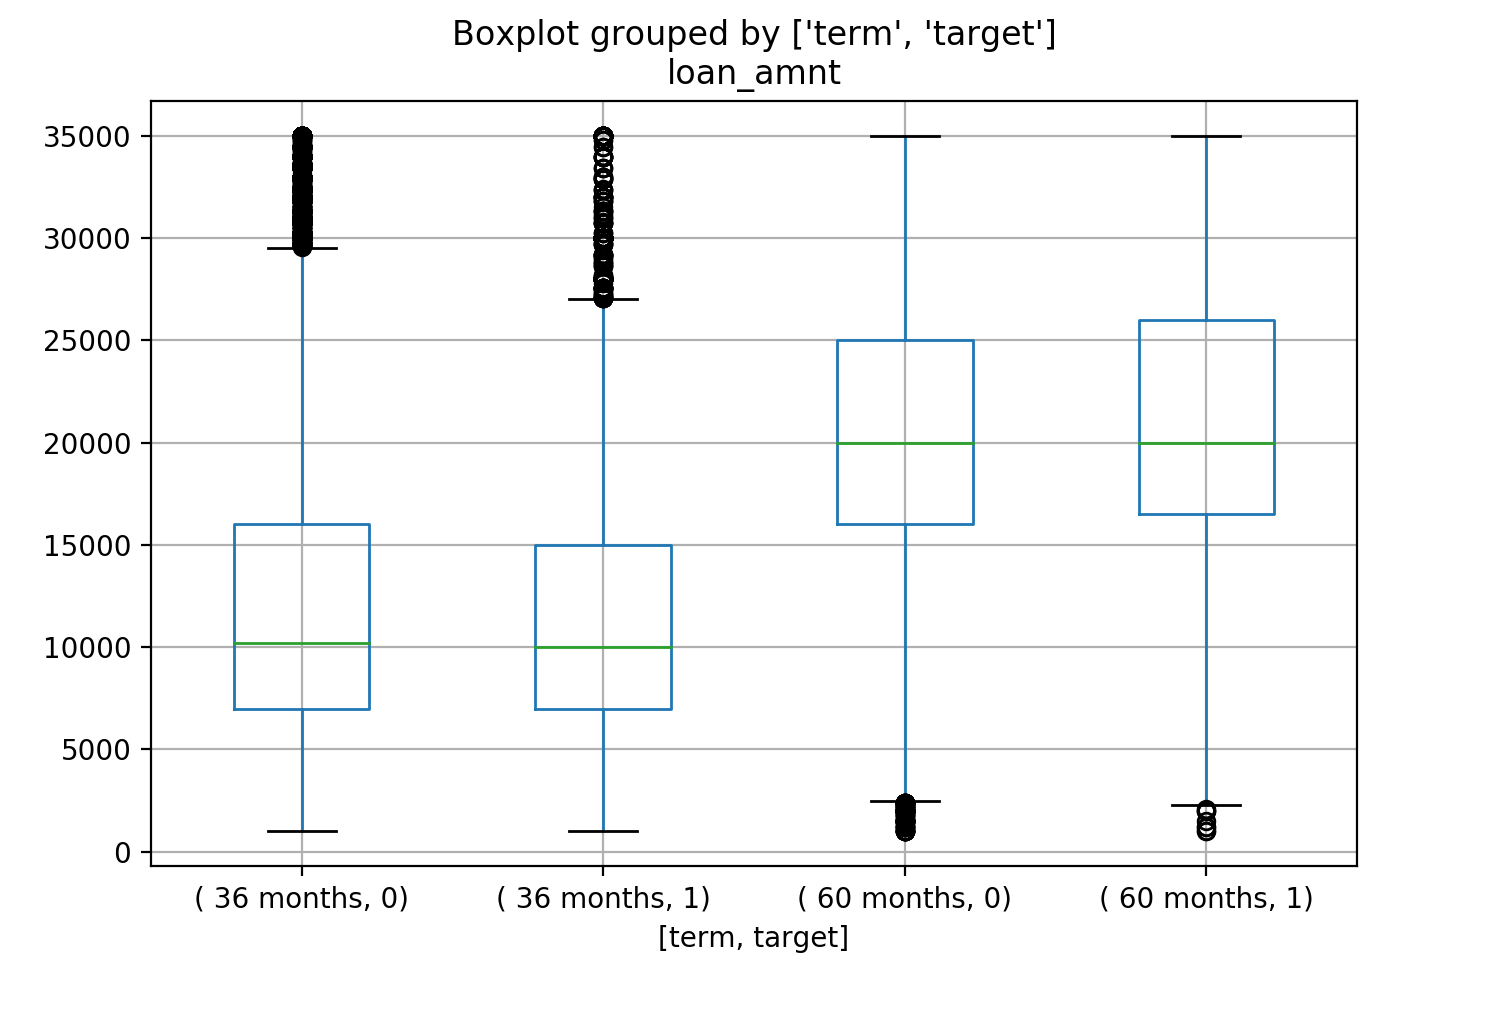

In [97]:
fig, ax = plt.subplots()
loan_data.boxplot(column='loan_amnt', by=['term', 'target'], ax=ax)
plt.show()

In [13]:
loan_data[['loan_amnt', 'target', 'term']].head()

,loan_amnt,target,term
0,7550,0,36 months
1,27050,0,36 months
2,12000,0,36 months
3,28000,0,36 months
4,12000,0,36 months


In [14]:
for i, d in loan_data.groupby(['term', 'target']):
    print(i[0], i[1])

 36 months 0
 36 months 1
 60 months 0
 60 months 1


<IPython.core.display.Javascript object>


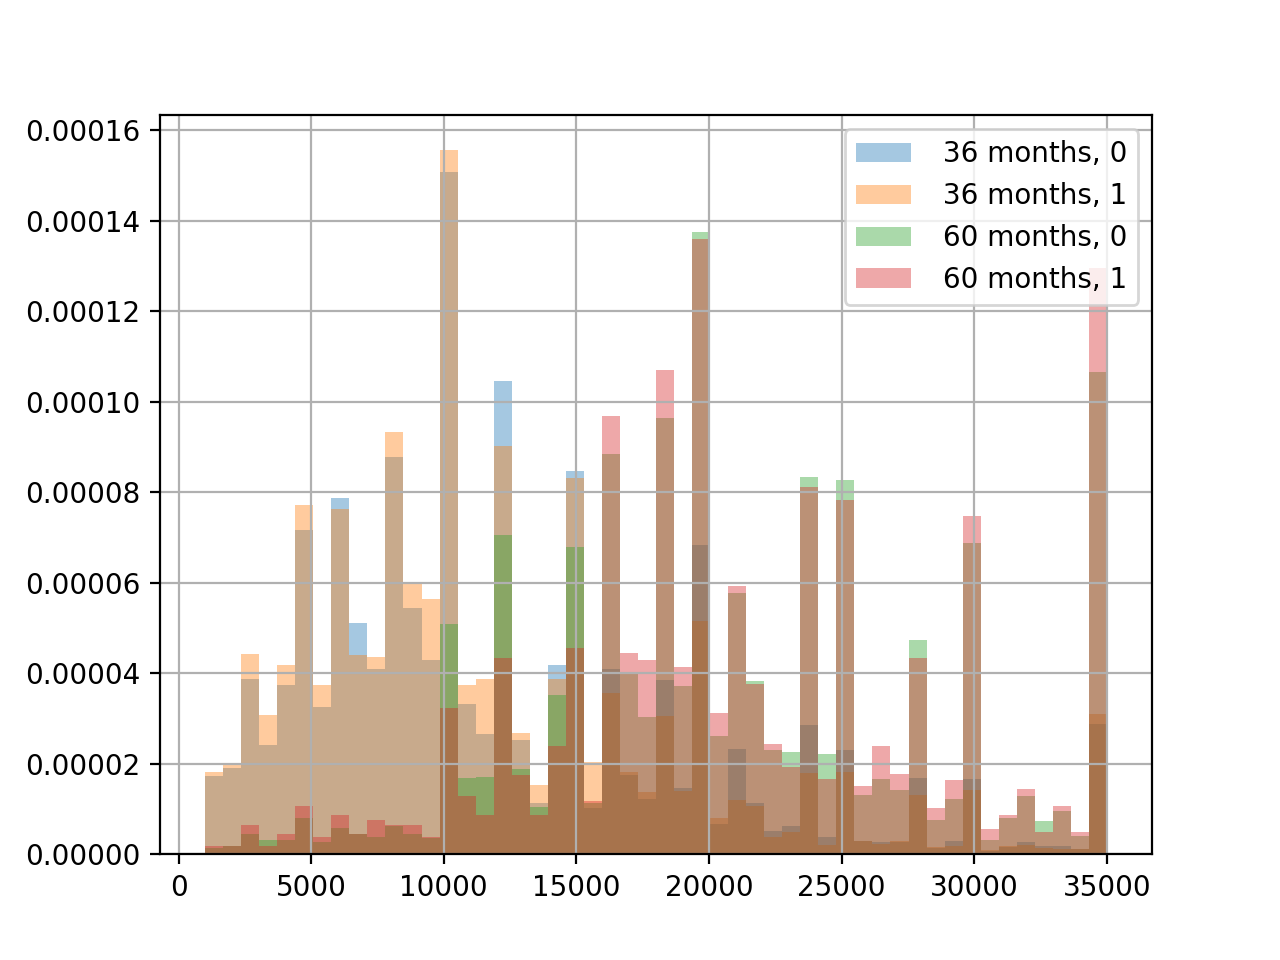

In [15]:
fig, ax = plt.subplots()
# loan_data[['loan_amnt', 'term', 'target']].hist(bins=50, alpha=0.4, by=['term', 'target'], ax=ax)
for i, d in loan_data.groupby(['term', 'target']):
#     loan_data.groupby(['term', 'target'])['loan_amnt'].hist(bins=50, alpha=0.4, ax=ax)
    d['loan_amnt'].hist(bins=50, alpha=0.4, ax=ax, label=str(i[0] + ', ' + str(i[1])), density=True)
    
plt.legend()
plt.show()

In [16]:
loan_data.groupby(['term', 'target'])['target'].count()

term        target
 36 months  0         134594
            1           9256
 60 months  0          40401
            1           3872
Name: target, dtype: int64

In [17]:
for i in loan_data.term.unique():
    print(i)
    print(loan_data.groupby(['term', 'target'])['target'].count().loc[i]\
          /loan_data.groupby(['term', 'target'])['target'].count().loc[i].sum())

 36 months
target
0    0.935655
1    0.064345
Name: target, dtype: float64
 60 months
target
0    0.912543
1    0.087457
Name: target, dtype: float64


In [18]:
# Employment length
loan_data.emp_length.value_counts(dropna=False)

10+ years    61175
2 years      16143
5 years      14265
3 years      13965
< 1 year     13222
6 years      11916
1 year       11434
7 years      11207
4 years      10846
8 years       8950
NaN           7877
9 years       7123
Name: emp_length, dtype: int64

In [19]:
loan_data.loc[loan_data.emp_length.isna(), 'target'].value_counts()

0    7220
1     657
Name: target, dtype: int64

In [20]:
new_loan_data.loc[new_loan_data.emp_length.isna()]

,loan_amnt,term,emp_length,home_ownership,annual_inc,desc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,target
91,10100,36 months,NaN,MORTGAGE,45000.00,Borrower added on 12/31/13 > I am requesting...,debt_consolidation,100.0,97.5,14.11,1.0,3.0,82%,8300.0,NaN,7677.147421,109987.0,0
94,9450,36 months,NaN,RENT,21900.00,NaN,credit_card,33.3,34.0,17.26,0.0,13.0,31.6%,5000.0,NaN,4517.612426,7969.0,0
116,35000,60 months,NaN,MORTGAGE,90000.00,NaN,debt_consolidation,50.0,87.6,24.45,0.0,10.0,88.9%,13400.0,NaN,13135.680874,315479.0,0
122,14125,60 months,NaN,RENT,35000.00,NaN,credit_card,0.0,50.3,26.17,0.0,12.0,33.1%,11500.0,NaN,12291.176149,28436.0,0
140,15375,36 months,NaN,MORTGAGE,44000.00,Borrower added on 12/30/13 > Debt Consolidat...,debt_consolidation,20.0,70.9,7.99,1.0,1.0,69.6%,8300.0,45.0,7796.377370,29788.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188074,5000,36 months,NaN,RENT,35000.00,Borrower added on 12/15/11 > I pay on time a...,debt_consolidation,NaN,NaN,14.67,0.0,NaN,2.3%,NaN,NaN,NaN,NaN,0
188086,7550,60 months,NaN,MORTGAGE,34626.00,Borrower added on 12/13/11 > I plan to use t...,debt_consolidation,NaN,NaN,19.75,2.0,NaN,72.7%,NaN,NaN,NaN,NaN,0
188104,7500,36 months,NaN,RENT,30000.00,NaN,credit_card,NaN,NaN,14.80,0.0,NaN,54.2%,NaN,NaN,NaN,NaN,0
188106,4000,36 months,NaN,MORTGAGE,24878.76,NaN,credit_card,NaN,NaN,8.20,2.0,NaN,99%,NaN,NaN,NaN,NaN,0


In [21]:
new_loan_data.loc[new_loan_data.emp_length.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7877 entries, 91 to 188121
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   loan_amnt                    7877 non-null   int64  
 1   term                         7877 non-null   object 
 2   emp_length                   0 non-null      object 
 3   home_ownership               7877 non-null   object 
 4   annual_inc                   7877 non-null   float64
 5   desc                         3480 non-null   object 
 6   purpose                      7877 non-null   object 
 7   percent_bc_gt_75             7542 non-null   float64
 8   bc_util                      7541 non-null   float64
 9   dti                          7877 non-null   float64
 10  inq_last_6mths               7877 non-null   float64
 11  mths_since_recent_inq        6571 non-null   float64
 12  revol_util                   7874 non-null   object 
 13  total_bc_limit 

In [22]:
new_loan_data.groupby(['emp_length', 'target'])['loan_amnt'].count()

emp_length  target
1 year      0         10619
            1           815
10+ years   0         57429
            1          3746
2 years     0         14993
            1          1150
3 years     0         12994
            1           971
4 years     0          9980
            1           866
5 years     0         13233
            1          1032
6 years     0         11001
            1           915
7 years     0         10415
            1           792
8 years     0          8343
            1           607
9 years     0          6624
            1           499
< 1 year    0         12144
            1          1078
Name: loan_amnt, dtype: int64

In [23]:
new_loan_data.loc[new_loan_data.emp_length.isna(), 'loan_amnt'].describe()

count     7877.000000
mean     11540.005713
std       7422.770608
min       1000.000000
25%       5750.000000
50%      10000.000000
75%      16000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [24]:
new_loan_data.loan_amnt.describe()

count    188123.000000
mean      14354.545962
std        8115.066458
min        1000.000000
25%        8000.000000
50%       12175.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

<IPython.core.display.Javascript object>


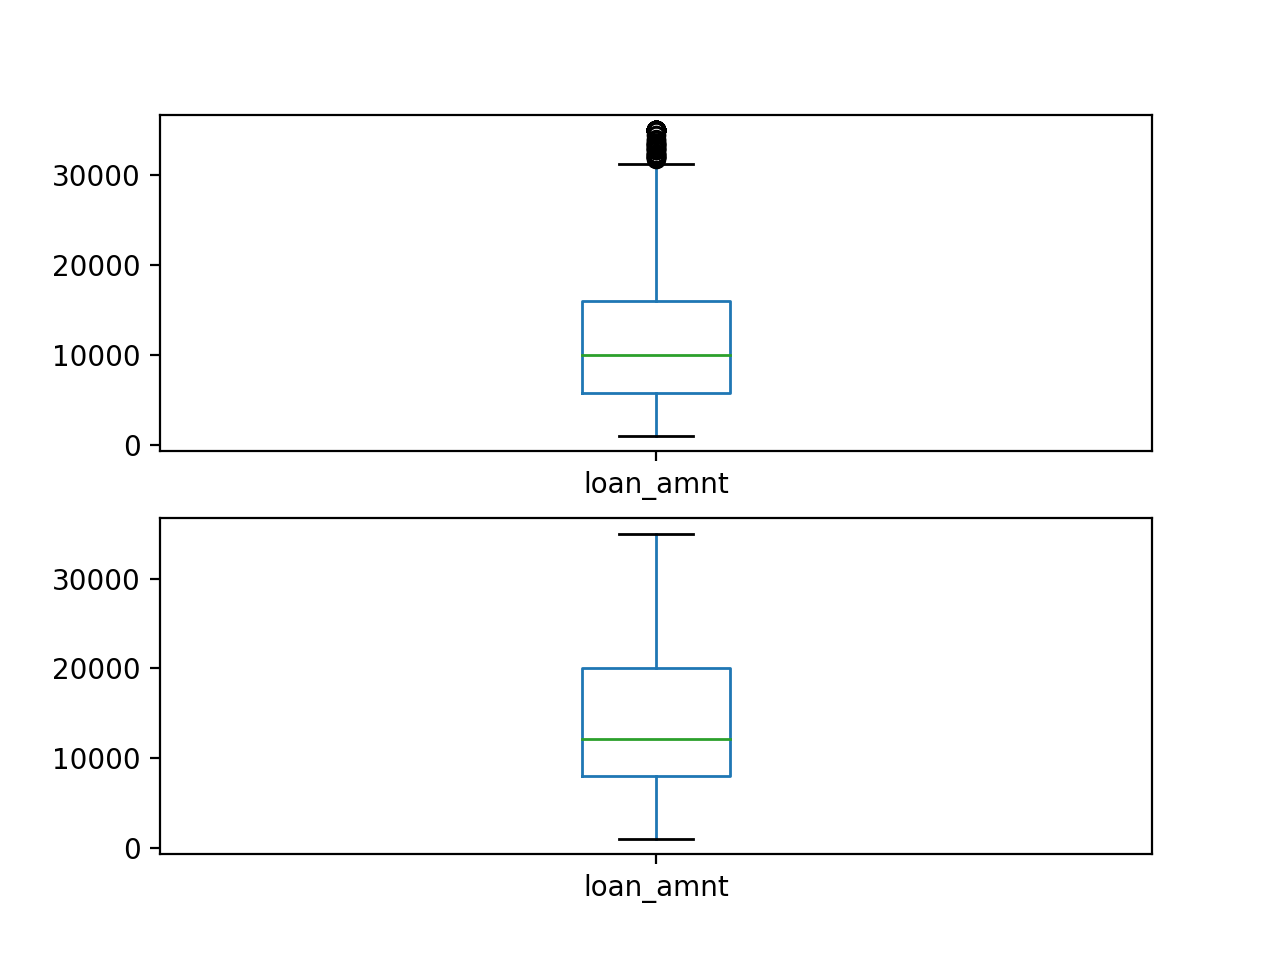

In [25]:
fig, ax = plt.subplots(2)
new_loan_data.loc[new_loan_data.emp_length.isna(), 'loan_amnt'].plot.box(ax=ax[0])
new_loan_data.loan_amnt.plot.box(ax=ax[1])
plt.show()

In [26]:
# Convert employmente length in to an integer and check the correlation with the other variables
new_loan_data['emp_length_yrs'] = new_loan_data.emp_length.str.extract(r'(\d+)').astype(float)
new_loan_data.emp_length_yrs.value_counts(dropna=False)

10.0    61175
1.0     24656
2.0     16143
5.0     14265
3.0     13965
6.0     11916
7.0     11207
4.0     10846
8.0      8950
NaN      7877
9.0      7123
Name: emp_length_yrs, dtype: int64

In [27]:
numeric_cols = new_loan_data.select_dtypes(exclude='object').columns.values
numeric_cols

array(['loan_amnt', 'annual_inc', 'percent_bc_gt_75', 'bc_util', 'dti',
       'inq_last_6mths', 'mths_since_recent_inq', 'total_bc_limit',
       'mths_since_last_major_derog', 'tot_hi_cred_lim', 'tot_cur_bal',
       'target', 'emp_length_yrs'], dtype=object)

In [28]:
new_loan_data[numeric_cols].corr()

,loan_amnt,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,target,emp_length_yrs
loan_amnt,1.000000,0.368178,0.007426,0.041829,0.044562,0.019807,-0.000090,0.365738,-0.079162,0.364562,0.314587,0.009113,0.115674
annual_inc,0.368178,1.000000,-0.039354,-0.020422,-0.196456,0.085232,-0.055011,0.292614,-0.095412,0.291102,0.491813,-0.041380,0.068021
percent_bc_gt_75,0.007426,-0.039354,1.000000,0.831839,0.192238,-0.080050,0.058963,-0.251153,0.038979,-0.250294,-0.009767,0.048968,0.032242
bc_util,0.041829,-0.020422,0.831839,1.000000,0.210827,-0.083061,0.058214,-0.292613,0.033011,-0.291608,0.002657,0.043119,0.037880
dti,0.044562,-0.196456,0.192238,0.210827,1.000000,0.011619,0.001031,0.032540,0.046727,0.032671,-0.016618,0.039879,0.042476
inq_last_6mths,0.019807,0.085232,-0.080050,-0.083061,0.011619,1.000000,-0.678859,0.010182,-0.004790,0.010207,0.103346,0.059380,-0.008354
mths_since_recent_inq,-0.000090,-0.055011,0.058963,0.058214,0.001031,-0.678859,1.000000,0.003825,-0.000125,0.003661,-0.066219,-0.052443,0.005855
total_bc_limit,0.365738,0.292614,-0.251153,-0.292613,0.032540,0.010182,0.003825,1.000000,-0.064415,0.996458,0.302445,-0.048020,0.064651
mths_since_last_major_derog,-0.079162,-0.095412,0.038979,0.033011,0.046727,-0.004790,-0.000125,-0.064415,1.000000,-0.063614,-0.108961,-0.002666,-0.012872
tot_hi_cred_lim,0.364562,0.291102,-0.250294,-0.291608,0.032671,0.010207,0.003661,0.996458,-0.063614,1.000000,0.301040,-0.047720,0.064184


In [29]:
new_loan_data[['percent_bc_gt_75', 'bc_util']].head(10)

,percent_bc_gt_75,bc_util
0,100.0,96.0
1,25.0,53.9
2,0.0,15.9
3,16.7,67.1
4,33.3,79.6
5,50.0,70.1
6,0.0,16.1
7,66.7,89.4
8,50.0,54.6
9,80.0,74.7


In [30]:
new_loan_data[['mths_since_recent_inq', 'inq_last_6mths']].head(10)

,mths_since_recent_inq,inq_last_6mths
0,17.0,0.0
1,8.0,0.0
2,3.0,1.0
3,3.0,1.0
4,17.0,0.0
5,14.0,0.0
6,3.0,2.0
7,8.0,0.0
8,0.0,2.0
9,6.0,1.0


In [31]:
new_loan_data.tot_hi_cred_lim.describe()

count    180628.000000
mean      20239.458973
std       18947.098163
min           0.000000
25%        7834.304802
50%       14635.958701
75%       26395.960437
max      520643.298178
Name: tot_hi_cred_lim, dtype: float64

In [32]:
print(new_loan_data.loc[new_loan_data.tot_hi_cred_lim == 0, 'tot_hi_cred_lim'].count())
print(new_loan_data.tot_hi_cred_lim.isna().sum())

1532
7495


In [33]:
# can drop 'total_bc_limit' because it is perfectly correlated with 'tot_hi_cred_lim'
new_loan_data.drop(columns=['total_bc_limit'], inplace=True)
# new_loan_data['tot_bal_cred_ratio'] = new_loan_data.tot_cur_bal / new_loan_data.tot_hi_cred_lim
# new_loan_data['tot_bal_cred_ratio'].head(10)
# replace the 0 values with NaN
new_loan_data.loc[new_loan_data.tot_hi_cred_lim == 0, 'tot_hi_cred_lim'] = np.nan

In [34]:
new_loan_data.bc_util.describe()

count    179012.000000
mean         66.829415
std          26.110808
min           0.000000
25%          49.500000
50%          72.200000
75%          89.000000
max         339.600000
Name: bc_util, dtype: float64

In [35]:
numeric_cols = new_loan_data.select_dtypes(exclude='object').columns.values
numeric_cols
new_loan_data[numeric_cols].corr()

,loan_amnt,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,target,emp_length_yrs
loan_amnt,1.000000,0.368178,0.007426,0.041829,0.044562,0.019807,-0.000090,-0.079162,0.363810,0.314587,0.009113,0.115674
annual_inc,0.368178,1.000000,-0.039354,-0.020422,-0.196456,0.085232,-0.055011,-0.095412,0.292813,0.491813,-0.041380,0.068021
percent_bc_gt_75,0.007426,-0.039354,1.000000,0.831839,0.192238,-0.080050,0.058963,0.038979,-0.250294,-0.009767,0.048968,0.032242
bc_util,0.041829,-0.020422,0.831839,1.000000,0.210827,-0.083061,0.058214,0.033011,-0.291673,0.002657,0.043119,0.037880
dti,0.044562,-0.196456,0.192238,0.210827,1.000000,0.011619,0.001031,0.046727,0.031525,-0.016618,0.039879,0.042476
inq_last_6mths,0.019807,0.085232,-0.080050,-0.083061,0.011619,1.000000,-0.678859,-0.004790,0.010158,0.103346,0.059380,-0.008354
mths_since_recent_inq,-0.000090,-0.055011,0.058963,0.058214,0.001031,-0.678859,1.000000,-0.000125,0.003383,-0.066219,-0.052443,0.005855
mths_since_last_major_derog,-0.079162,-0.095412,0.038979,0.033011,0.046727,-0.004790,-0.000125,1.000000,-0.067099,-0.108961,-0.002666,-0.012872
tot_hi_cred_lim,0.363810,0.292813,-0.250294,-0.291673,0.031525,0.010158,0.003383,-0.067099,1.000000,0.304235,-0.046900,0.064993
tot_cur_bal,0.314587,0.491813,-0.009767,0.002657,-0.016618,0.103346,-0.066219,-0.108961,0.304235,1.000000,-0.039838,0.096087


In [36]:
# drop description
new_loan_data.drop(columns=['desc'], inplace=True)

In [37]:
new_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    188123 non-null  int64  
 1   term                         188123 non-null  object 
 2   emp_length                   180246 non-null  object 
 3   home_ownership               188123 non-null  object 
 4   annual_inc                   188123 non-null  float64
 5   purpose                      188123 non-null  object 
 6   percent_bc_gt_75             179096 non-null  float64
 7   bc_util                      179012 non-null  float64
 8   dti                          188123 non-null  float64
 9   inq_last_6mths               188123 non-null  float64
 10  mths_since_recent_inq        160263 non-null  float64
 11  revol_util                   187998 non-null  object 
 12  mths_since_last_major_derog  32497 non-null   float64
 13 

In [38]:
# let's drop 'mths_since_last_major_derog' since it has a very low correlation with 
# the target variable, but moreover it has only 17% data. Not useful!
new_loan_data.drop(columns=['mths_since_last_major_derog'], inplace=True)

In [39]:
new_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              188123 non-null  int64  
 1   term                   188123 non-null  object 
 2   emp_length             180246 non-null  object 
 3   home_ownership         188123 non-null  object 
 4   annual_inc             188123 non-null  float64
 5   purpose                188123 non-null  object 
 6   percent_bc_gt_75       179096 non-null  float64
 7   bc_util                179012 non-null  float64
 8   dti                    188123 non-null  float64
 9   inq_last_6mths         188123 non-null  float64
 10  mths_since_recent_inq  160263 non-null  float64
 11  revol_util             187998 non-null  object 
 12  tot_hi_cred_lim        179096 non-null  float64
 13  tot_cur_bal            160382 non-null  float64
 14  target                 188123 non-nu

In [40]:
# Process the loan data before passing it as features to the classifier
new_loan_data.drop(columns='emp_length', inplace=True)  # first drop employment length because we have two 
# columns with the same data

In [41]:
new_loan_data.head(10)

,loan_amnt,term,home_ownership,annual_inc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,tot_hi_cred_lim,tot_cur_bal,target,emp_length_yrs
0,7550,36 months,RENT,28000.0,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72%,3828.953801,5759.0,0,3.0
1,27050,36 months,OWN,55000.0,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.2%,34359.940727,114834.0,0,10.0
2,12000,36 months,RENT,60000.0,debt_consolidation,0.0,15.9,4.62,1.0,3.0,24%,16416.617758,7137.0,0,4.0
3,28000,36 months,MORTGAGE,325000.0,debt_consolidation,16.7,67.1,18.55,1.0,3.0,54.6%,38014.149757,799592.0,0,5.0
4,12000,36 months,RENT,40000.0,debt_consolidation,33.3,79.6,16.94,0.0,17.0,68.8%,6471.462236,13605.0,0,10.0
5,11500,60 months,RENT,32760.0,debt_consolidation,50.0,70.1,27.06,0.0,14.0,70.9%,9750.303073,24724.0,0,4.0
6,4800,36 months,MORTGAGE,39600.0,home_improvement,0.0,16.1,2.49,2.0,3.0,16.1%,24491.154755,4136.0,0,2.0
7,10000,36 months,MORTGAGE,102000.0,debt_consolidation,66.7,89.4,15.55,0.0,8.0,44.4%,9401.851428,39143.0,0,7.0
8,20800,36 months,RENT,81500.0,debt_consolidation,50.0,54.6,16.73,2.0,0.0,54.5%,15014.232744,23473.0,0,10.0
9,27600,60 months,MORTGAGE,73000.0,debt_consolidation,80.0,74.7,23.13,1.0,6.0,82.8%,20011.337149,241609.0,0,6.0


In [42]:
new_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              188123 non-null  int64  
 1   term                   188123 non-null  object 
 2   home_ownership         188123 non-null  object 
 3   annual_inc             188123 non-null  float64
 4   purpose                188123 non-null  object 
 5   percent_bc_gt_75       179096 non-null  float64
 6   bc_util                179012 non-null  float64
 7   dti                    188123 non-null  float64
 8   inq_last_6mths         188123 non-null  float64
 9   mths_since_recent_inq  160263 non-null  float64
 10  revol_util             187998 non-null  object 
 11  tot_hi_cred_lim        179096 non-null  float64
 12  tot_cur_bal            160382 non-null  float64
 13  target                 188123 non-null  int64  
 14  emp_length_yrs         180246 non-nu

In [43]:
# extract the numeric values from revolving utilization
new_loan_data['revol_util'] = new_loan_data.revol_util.str.replace("%", "").astype(float)
new_loan_data['revol_util'].describe()

count    187998.000000
mean         58.386538
std          23.009050
min           0.000000
25%          42.500000
50%          60.500000
75%          76.600000
max         140.400000
Name: revol_util, dtype: float64

In [44]:
new_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              188123 non-null  int64  
 1   term                   188123 non-null  object 
 2   home_ownership         188123 non-null  object 
 3   annual_inc             188123 non-null  float64
 4   purpose                188123 non-null  object 
 5   percent_bc_gt_75       179096 non-null  float64
 6   bc_util                179012 non-null  float64
 7   dti                    188123 non-null  float64
 8   inq_last_6mths         188123 non-null  float64
 9   mths_since_recent_inq  160263 non-null  float64
 10  revol_util             187998 non-null  float64
 11  tot_hi_cred_lim        179096 non-null  float64
 12  tot_cur_bal            160382 non-null  float64
 13  target                 188123 non-null  int64  
 14  emp_length_yrs         180246 non-nu

## Need to fill in the missing values for the numeric columns

### Strategy 1: fill in missing values using the median value of the feature

In [45]:
# Let's fill in the missing values with the median value of the feature
numeric_cols = new_loan_data.select_dtypes(exclude='object').columns.values

for i in numeric_cols:
    if new_loan_data[i].isna().sum() > 0:
        new_loan_data[i].fillna(new_loan_data[i].median(), inplace=True)
        
new_loan_data.isna().sum().sum()

0

In [46]:
new_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              188123 non-null  int64  
 1   term                   188123 non-null  object 
 2   home_ownership         188123 non-null  object 
 3   annual_inc             188123 non-null  float64
 4   purpose                188123 non-null  object 
 5   percent_bc_gt_75       188123 non-null  float64
 6   bc_util                188123 non-null  float64
 7   dti                    188123 non-null  float64
 8   inq_last_6mths         188123 non-null  float64
 9   mths_since_recent_inq  188123 non-null  float64
 10  revol_util             188123 non-null  float64
 11  tot_hi_cred_lim        188123 non-null  float64
 12  tot_cur_bal            188123 non-null  float64
 13  target                 188123 non-null  int64  
 14  emp_length_yrs         188123 non-nu

In [47]:
# we need to convert categorical columns to one-hot encoded values
object_cols = new_loan_data.select_dtypes(include='object').columns.values

feat_df = pd.get_dummies(new_loan_data, columns=object_cols, prefix_sep=": ", dummy_na=True, drop_first=True)
feat_df.head(5)

,loan_amnt,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,tot_hi_cred_lim,tot_cur_bal,...,purpose: house,purpose: major_purchase,purpose: medical,purpose: moving,purpose: other,purpose: renewable_energy,purpose: small_business,purpose: vacation,purpose: wedding,purpose: nan
0,7550,28000.0,100.0,96.0,8.40,0.0,17.0,72.0,3828.953801,5759.0,...,0,0,0,0,0,0,0,0,0,0
1,27050,55000.0,25.0,53.9,22.87,0.0,8.0,61.2,34359.940727,114834.0,...,0,0,0,0,0,0,0,0,0,0
2,12000,60000.0,0.0,15.9,4.62,1.0,3.0,24.0,16416.617758,7137.0,...,0,0,0,0,0,0,0,0,0,0
3,28000,325000.0,16.7,67.1,18.55,1.0,3.0,54.6,38014.149757,799592.0,...,0,0,0,0,0,0,0,0,0,0
4,12000,40000.0,33.3,79.6,16.94,0.0,17.0,68.8,6471.462236,13605.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    188123 non-null  int64  
 1   annual_inc                   188123 non-null  float64
 2   percent_bc_gt_75             188123 non-null  float64
 3   bc_util                      188123 non-null  float64
 4   dti                          188123 non-null  float64
 5   inq_last_6mths               188123 non-null  float64
 6   mths_since_recent_inq        188123 non-null  float64
 7   revol_util                   188123 non-null  float64
 8   tot_hi_cred_lim              188123 non-null  float64
 9   tot_cur_bal                  188123 non-null  float64
 10  target                       188123 non-null  int64  
 11  emp_length_yrs               188123 non-null  float64
 12  term:  60 months             188123 non-null  uint8  
 13 

In [49]:
X = feat_df.copy()
X.drop(columns=['target'], inplace=True)
y = feat_df.target.values.reshape(-1, 1)

In [50]:
# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y, train_size=0.7)

In [51]:
# Let us check the percentage of defaults in the train and test
print("Train:", np.unique(y_train, return_counts=True)[1]/len(y_train))
print("Test:", np.unique(y_test, return_counts=True)[1]/len(y_test))

Train: [0.93021278 0.06978722]
Test: [0.93022308 0.06977692]


In [108]:
x_train.shape, x_test.shape

((131686, 31), (56437, 31))

In [52]:
x_train.describe()

,loan_amnt,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,tot_hi_cred_lim,tot_cur_bal,...,purpose: house,purpose: major_purchase,purpose: medical,purpose: moving,purpose: other,purpose: renewable_energy,purpose: small_business,purpose: vacation,purpose: wedding,purpose: nan
count,131686.000000,1.316860e+05,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,1.316860e+05,...,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,131686.000000,131686.0
mean,14350.863607,7.213495e+04,53.535577,67.152973,17.061670,0.802690,6.840234,58.499962,20147.468602,1.289292e+05,...,0.005931,0.019349,0.008368,0.005468,0.047150,0.000676,0.014770,0.004708,0.007245,0.0
std,8112.100105,4.594000e+04,33.276427,25.489831,7.592394,1.031958,5.439226,23.008842,18555.460251,1.388965e+05,...,0.076783,0.137749,0.091096,0.073741,0.211961,0.025988,0.120631,0.068455,0.084806,0.0
min,1000.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.232299,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,8000.000000,4.500000e+04,28.600000,51.100000,11.340000,0.000000,3.000000,42.600000,8259.903124,3.200450e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,12100.000000,6.200000e+04,50.000000,72.200000,16.800000,0.000000,6.000000,60.600000,14773.242158,8.076400e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,20000.000000,8.700000e+04,80.000000,88.300000,22.570000,1.000000,9.000000,76.700000,25706.731950,1.852085e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,35000.000000,2.000000e+06,100.000000,339.600000,34.990000,8.000000,24.000000,140.400000,520643.298178,3.471522e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [64]:
scoring = {'auc_score': make_scorer(roc_auc_score)}

In [74]:
# Define the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=SEED, class_weight='balanced')
rf.fit(x_train, y_train)
preds = rf.predict(x_test)
print(confusion_matrix(y_test, preds), roc_auc_score(y_test, rf.predict_proba(x_test)[:, 1]))
# Perform cross-validation
scoring = {'auc_score': make_scorer(roc_auc_score)}
cv = cross_validate(rf.fit(x_train, y_train), x_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
print(cv)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[[52166   333]
 [ 3873    65]] 0.5535583032847147


/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


{'fit_time': array([0.65147495, 0.37500691, 0.68452311, 0.39987707, 0.57942295]), 'score_time': array([0.11116385, 0.11333299, 0.11115909, 0.11249518, 0.11300397]), 'test_auc_score': array([0.50647367, 0.50435851, 0.50337241, 0.50368501, 0.50365789])}


In [162]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=SEED, n_jobs=-1, C=0.01, class_weight='balanced')
lr.fit(x_train, y_train)
preds = lr.predict(x_test)
print(confusion_matrix(y_test, preds), roc_auc_score(y_test, lr.predict_proba(x_test)[:, 1]))
cv = cross_validate(lr.fit(x_train, y_train), x_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
print(cv)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[25450 27049]
 [ 1317  2621]] 0.6063743108758917


/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'fit_time': array([1.01216984, 0.98814201, 1.05534291, 0.86633587, 0.9333818 ]), 'score_time': array([0.00914097, 0.01332617, 0.00718808, 0.01866102, 0.00942326]), 'test_auc_score': array([0.56529242, 0.57833897, 0.56821296, 0.57457827, 0.57785017])}


## Read in the test data and compare the performance metrics

In [111]:
test_data_filename = '/Users/ankurmanikandan/Desktop/Missiona Lane Data Assessment/drive-download-20200505T201443Z-001/testing_data.csv'
test_loan_data = pd.read_csv(test_data_filename, skiprows=1)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,4,5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [112]:
test_loan_data.head(10)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,desc,...,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,total_pymnt,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal
0,20159237,22421876.0,10000.0,36 months,22.15%,8 years,RENT,37000.0,Current,NaN,...,83.0,28.51,1.0,3.0,73.1%,16200.0,382.6900,NaN,14877.170282,36809.0
1,20088512,22351142.0,1400.0,36 months,18.24%,6 years,RENT,41000.0,Current,NaN,...,0.0,26.58,0.0,9.0,11.5%,4000.0,65.7900,NaN,4097.304770,19536.0
2,20138199,22400842.0,7000.0,36 months,12.49%,3 years,RENT,68900.0,Current,NaN,...,75.9,6.60,0.0,11.0,48.1%,11900.0,234.1500,80.0,12688.495161,241465.0
3,20158360,22421039.0,18000.0,60 months,16.29%,9 years,MORTGAGE,41000.0,Current,NaN,...,61.1,20.61,1.0,0.0,38.1%,7600.0,881.0200,73.0,7908.799817,179757.0
4,20127968,22390638.0,12000.0,36 months,12.99%,10+ years,MORTGAGE,64000.0,Current,NaN,...,67.0,24.61,0.0,NaN,57.9%,21000.0,808.5400,NaN,19378.561062,31953.0
5,20077585,22340282.0,6900.0,36 months,11.67%,8 years,RENT,70000.0,Fully Paid,NaN,...,23.8,8.52,0.0,20.0,28.1%,29800.0,6967.1025,NaN,28395.922806,15100.0
6,12586984,14599155.0,7250.0,36 months,16.29%,4 years,MORTGAGE,90000.0,Current,NaN,...,39.7,6.59,3.0,1.0,25.1%,2400.0,511.8600,NaN,2441.213440,25914.0
7,20047278,22310007.0,3850.0,36 months,16.99%,2 years,RENT,28000.0,Current,NaN,...,65.3,16.25,1.0,2.0,50.2%,4000.0,274.5000,NaN,4241.186825,9603.0
8,20167173,22429914.0,32225.0,60 months,22.15%,9 years,RENT,77000.0,Current,NaN,...,81.5,26.48,2.0,6.0,72.3%,23300.0,1785.5400,NaN,23427.330456,54468.0
9,20107159,22369906.0,10000.0,36 months,16.29%,< 1 year,MORTGAGE,60000.0,Current,NaN,...,7.6,9.20,3.0,1.0,8.5%,28300.0,706.0200,45.0,28799.606055,162891.0


In [115]:
test_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           138735 non-null  int64  
 1   member_id                    102505 non-null  float64
 2   loan_amnt                    138735 non-null  float64
 3   term                         102505 non-null  object 
 4   int_rate                     102505 non-null  object 
 5   emp_length                   97184 non-null   object 
 6   home_ownership               102505 non-null  object 
 7   annual_inc                   102505 non-null  float64
 8   loan_status                  102505 non-null  object 
 9   desc                         15194 non-null   object 
 10  purpose                      102505 non-null  object 
 11  percent_bc_gt_75             101459 non-null  float64
 12  bc_util                      101463 non-null  float64
 13 

In [116]:
new_loan_data.columns

Index(['loan_amnt', 'term', 'home_ownership', 'annual_inc', 'purpose',
       'percent_bc_gt_75', 'bc_util', 'dti', 'inq_last_6mths',
       'mths_since_recent_inq', 'revol_util', 'tot_hi_cred_lim', 'tot_cur_bal',
       'target', 'emp_length_yrs'],
      dtype='object')

In [118]:
common_cols = new_loan_data.columns.values[new_loan_data.columns.isin(test_loan_data.columns)]
common_cols

array(['loan_amnt', 'term', 'home_ownership', 'annual_inc', 'purpose',
       'percent_bc_gt_75', 'bc_util', 'dti', 'inq_last_6mths',
       'mths_since_recent_inq', 'revol_util', 'tot_hi_cred_lim',
       'tot_cur_bal'], dtype=object)

In [119]:
# Remove all the column we don't need
new_test_loan_data = test_loan_data[common_cols].copy()
new_test_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              138735 non-null  float64
 1   term                   102505 non-null  object 
 2   home_ownership         102505 non-null  object 
 3   annual_inc             102505 non-null  float64
 4   purpose                102505 non-null  object 
 5   percent_bc_gt_75       101459 non-null  float64
 6   bc_util                101463 non-null  float64
 7   dti                    102505 non-null  float64
 8   inq_last_6mths         102505 non-null  float64
 9   mths_since_recent_inq  93677 non-null   float64
 10  revol_util             102457 non-null  object 
 11  tot_hi_cred_lim        102505 non-null  float64
 12  tot_cur_bal            102505 non-null  float64
dtypes: float64(9), object(4)
memory usage: 13.8+ MB


In [122]:
test_loan_data.loan_status.value_counts()

Current               97518
Fully Paid             3442
Late (31-120 days)      642
In Grace Period         569
Late (16-30 days)       223
Charged Off             105
Default                   6
Name: loan_status, dtype: int64

In [120]:
# Create the target column
new_test_loan_data['target'] = np.where(test_loan_data.loan_status.isin(default_loan_status), 1, 0)
new_test_loan_data.target.value_counts(dropna=False)

0    137759
1       976
Name: target, dtype: int64

In [121]:
print(new_loan_data.target.value_counts(normalize=True))
print(new_test_loan_data.target.value_counts(normalize=True))

0    0.930216
1    0.069784
Name: target, dtype: float64
0    0.992965
1    0.007035
Name: target, dtype: float64


In [123]:
new_test_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              138735 non-null  float64
 1   term                   102505 non-null  object 
 2   home_ownership         102505 non-null  object 
 3   annual_inc             102505 non-null  float64
 4   purpose                102505 non-null  object 
 5   percent_bc_gt_75       101459 non-null  float64
 6   bc_util                101463 non-null  float64
 7   dti                    102505 non-null  float64
 8   inq_last_6mths         102505 non-null  float64
 9   mths_since_recent_inq  93677 non-null   float64
 10  revol_util             102457 non-null  object 
 11  tot_hi_cred_lim        102505 non-null  float64
 12  tot_cur_bal            102505 non-null  float64
 13  target                 138735 non-null  int64  
dtypes: float64(9), int64(1), object(4)
m

In [124]:
# Employment length
test_loan_data.emp_length.value_counts(dropna=False)

NaN          41551
10+ years    34896
2 years       8686
3 years       7912
< 1 year      7435
1 year        6102
5 years       6050
7 years       5899
4 years       5613
6 years       5411
8 years       5109
9 years       4071
Name: emp_length, dtype: int64

In [129]:
# Extract the employment length
new_test_loan_data['emp_length_yrs'] = test_loan_data.emp_length.str.extract(r'(\d+)').astype(float)
new_test_loan_data.emp_length_yrs.value_counts(dropna=False)

NaN     41551
10.0    34896
1.0     13537
2.0      8686
3.0      7912
5.0      6050
7.0      5899
4.0      5613
6.0      5411
8.0      5109
9.0      4071
Name: emp_length_yrs, dtype: int64

In [130]:
# Convert revoliving utilization to a float
new_test_loan_data['revol_util'] = new_test_loan_data.revol_util.str.replace("%", "").astype(float)
new_test_loan_data['revol_util'].describe()

count    102457.000000
mean         55.898129
std          22.862373
min           0.000000
25%          39.500000
50%          56.600000
75%          73.300000
max         892.300000
Name: revol_util, dtype: float64

In [132]:
new_test_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              138735 non-null  float64
 1   term                   102505 non-null  object 
 2   home_ownership         102505 non-null  object 
 3   annual_inc             102505 non-null  float64
 4   purpose                102505 non-null  object 
 5   percent_bc_gt_75       101459 non-null  float64
 6   bc_util                101463 non-null  float64
 7   dti                    102505 non-null  float64
 8   inq_last_6mths         102505 non-null  float64
 9   mths_since_recent_inq  93677 non-null   float64
 10  revol_util             102457 non-null  float64
 11  tot_hi_cred_lim        102505 non-null  float64
 12  tot_cur_bal            102505 non-null  float64
 13  target                 138735 non-null  int64  
 14  emp_length_yrs         97184 non-nul

In [153]:
# Fill in the missing values in the numeric columns
test_numeric_cols = new_test_loan_data.select_dtypes(exclude='object').columns.values

for i in test_numeric_cols:
    new_test_loan_data.loc[new_test_loan_data[i].isna(), i] = new_test_loan_data[i].median()
    
new_test_loan_data.info()

loan_amnt
annual_inc
percent_bc_gt_75
bc_util
dti
inq_last_6mths
mths_since_recent_inq
revol_util
tot_hi_cred_lim
tot_cur_bal
target
emp_length_yrs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              138735 non-null  float64
 1   term                   102505 non-null  object 
 2   home_ownership         102505 non-null  object 
 3   annual_inc             138735 non-null  float64
 4   purpose                102505 non-null  object 
 5   percent_bc_gt_75       138735 non-null  float64
 6   bc_util                138735 non-null  float64
 7   dti                    138735 non-null  float64
 8   inq_last_6mths         138735 non-null  float64
 9   mths_since_recent_inq  138735 non-null  float64
 10  revol_util             138735 non-null  float64
 11  tot_hi_cred_lim        138735 non-null  float64

In [154]:
# Create the test feature dataset
test_object_cols = new_test_loan_data.select_dtypes(include='object').columns.values

test_feat_df = pd.get_dummies(new_test_loan_data, prefix_sep=": ", columns=test_object_cols,
                             dummy_na=True, drop_first=True)
test_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    138735 non-null  float64
 1   annual_inc                   138735 non-null  float64
 2   percent_bc_gt_75             138735 non-null  float64
 3   bc_util                      138735 non-null  float64
 4   dti                          138735 non-null  float64
 5   inq_last_6mths               138735 non-null  float64
 6   mths_since_recent_inq        138735 non-null  float64
 7   revol_util                   138735 non-null  float64
 8   tot_hi_cred_lim              138735 non-null  float64
 9   tot_cur_bal                  138735 non-null  float64
 10  target                       138735 non-null  float64
 11  emp_length_yrs               138735 non-null  float64
 12  term:  60 months             138735 non-null  uint8  
 13 

In [155]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    188123 non-null  int64  
 1   annual_inc                   188123 non-null  float64
 2   percent_bc_gt_75             188123 non-null  float64
 3   bc_util                      188123 non-null  float64
 4   dti                          188123 non-null  float64
 5   inq_last_6mths               188123 non-null  float64
 6   mths_since_recent_inq        188123 non-null  float64
 7   revol_util                   188123 non-null  float64
 8   tot_hi_cred_lim              188123 non-null  float64
 9   tot_cur_bal                  188123 non-null  float64
 10  target                       188123 non-null  int64  
 11  emp_length_yrs               188123 non-null  float64
 12  term:  60 months             188123 non-null  uint8  
 13 

In [156]:
# Identify missing columns if any
missing_cols = feat_df.columns.values[~feat_df.columns.isin(test_feat_df.columns)]
missing_cols

array(['home_ownership: NONE', 'home_ownership: OTHER'], dtype=object)

In [157]:
# add the missing columns to test feature dataset
for i in missing_cols:
    test_feat_df[i] = np.zeros(len(test_feat_df), dtype=int)
    
# Rearrange the columns to match the training feature order
test_feat_df = test_feat_df[feat_df.columns]

test_feat_df.head(10)

,loan_amnt,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,tot_hi_cred_lim,tot_cur_bal,...,purpose: house,purpose: major_purchase,purpose: medical,purpose: moving,purpose: other,purpose: renewable_energy,purpose: small_business,purpose: vacation,purpose: wedding,purpose: nan
0,10000.0,37000.0,80.0,83.0,28.51,1.0,3.0,73.1,14877.170282,36809.0,...,0,0,0,0,0,0,0,0,0,0
1,1400.0,41000.0,0.0,0.0,26.58,0.0,9.0,11.5,4097.304770,19536.0,...,0,0,0,0,1,0,0,0,0,0
2,7000.0,68900.0,60.0,75.9,6.60,0.0,11.0,48.1,12688.495161,241465.0,...,0,0,0,0,0,0,0,0,0,0
3,18000.0,41000.0,33.3,61.1,20.61,1.0,0.0,38.1,7908.799817,179757.0,...,0,0,0,0,0,0,0,0,0,0
4,12000.0,64000.0,75.0,67.0,24.61,0.0,6.0,57.9,19378.561062,31953.0,...,0,0,0,0,0,0,0,0,0,0
5,6900.0,70000.0,33.3,23.8,8.52,0.0,20.0,28.1,28395.922806,15100.0,...,0,0,0,0,0,0,0,0,0,0
6,7250.0,90000.0,50.0,39.7,6.59,3.0,1.0,25.1,2441.213440,25914.0,...,0,0,0,0,0,0,0,0,0,0
7,3850.0,28000.0,25.0,65.3,16.25,1.0,2.0,50.2,4241.186825,9603.0,...,0,0,0,0,0,0,0,0,0,0
8,32225.0,77000.0,71.4,81.5,26.48,2.0,6.0,72.3,23427.330456,54468.0,...,0,0,0,0,0,0,0,0,0,0
9,10000.0,60000.0,0.0,7.6,9.20,3.0,1.0,8.5,28799.606055,162891.0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
test_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    138735 non-null  float64
 1   annual_inc                   138735 non-null  float64
 2   percent_bc_gt_75             138735 non-null  float64
 3   bc_util                      138735 non-null  float64
 4   dti                          138735 non-null  float64
 5   inq_last_6mths               138735 non-null  float64
 6   mths_since_recent_inq        138735 non-null  float64
 7   revol_util                   138735 non-null  float64
 8   tot_hi_cred_lim              138735 non-null  float64
 9   tot_cur_bal                  138735 non-null  float64
 10  target                       138735 non-null  float64
 11  emp_length_yrs               138735 non-null  float64
 12  term:  60 months             138735 non-null  uint8  
 13 

In [159]:
# Split the data
test_x = test_feat_df.copy()
test_x.drop(columns='target', inplace=True)
test_y = test_feat_df.target.values

In [163]:
# Get the predictions from the Logistic Regression Classifier
y_pred = lr.predict(test_x)
print(confusion_matrix(test_y, y_pred), roc_auc_score(test_y, lr.predict_proba(test_x)[:, 1]))

[[77742 60017]
 [  388   588]] 0.5912015031239516


In [161]:
# Get the predictions from the Logistic Regression Classifier
y_pred = rf.predict(test_x)
print(confusion_matrix(test_y, y_pred), roc_auc_score(test_y, rf.predict_proba(test_x)[:, 1]))

[[137393    366]
 [   969      7]] 0.5570749208138376
